In [1]:
import numpy as np
import TensorFrost as tf
import matplotlib.pyplot as plt

tf.initialize(tf.opengl)

def Scan():
    data = tf.input([-1], tf.int32)
    N = data.shape[0]
    group_size = 128
    groups = (N + group_size - 1) / group_size

    sums = tf.buffer([groups], tf.int32)
    group_scans = tf.buffer([groups], tf.int32)
    full_scan = tf.buffer([N], tf.int32)
    gid, = sums.indices

    counter = tf.zeros([], tf.int32)
    def sum_loop(i):
        index = gid * group_size + i
        tf.if_cond(index >= N, lambda: tf.break_loop())
        counter.set(counter + data[index])
    tf.loop(sum_loop, 0, group_size, 1)
    sums[gid] = counter

    scan = tf.zeros([1], tf.int32)
    def scan_loop(i):
        scan.set(scan + sums[i])
        group_scans[i] = scan
    tf.loop(scan_loop, 0, groups, 1)

    local_scan = tf.select(gid > 0, group_scans[gid - 1], 0)
    def local_scan_loop(i):
        index = gid * group_size + i
        tf.if_cond(index >= N, lambda: tf.break_loop())
        local_scan.set(local_scan + data[index])
        full_scan[index] = local_scan
    tf.loop(local_scan_loop, 0, group_size, 1)

    return [full_scan]

scan_program = tf.compile(Scan)

TensorFrost module loaded!
Scan:
  Kernel count: 3
  Intermediate buffers: 2
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 467
  IR Compile time: 0.724100 ms
  Compiler time: 1344.469849 ms



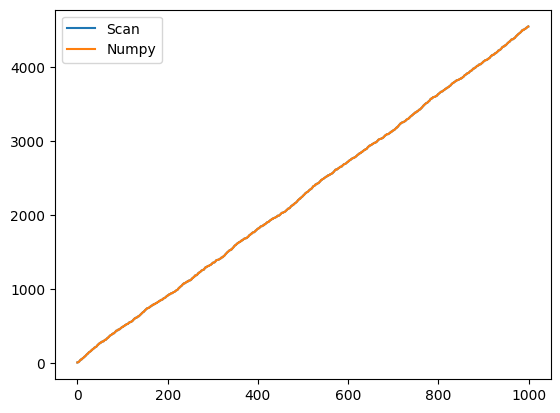

Error:  0


In [2]:
# Generate some random data to scan (ints between 0 and 10)
data = np.random.randint(0, 10, 1000, dtype=np.int32)

data_tf = tf.tensor(data)
scan_tf, = scan_program(data_tf)

# do scan in numpy
scan_np = np.cumsum(data)

# Plot the original data and the scan
scan = scan_tf.numpy
plt.plot(scan, label="Scan")
plt.plot(scan_np, label="Numpy")
plt.legend()
plt.show()

#print error
print("Error: ", np.max(np.abs(scan - scan_np)))